In [1]:
library(sp);
library(rgeos)
library(maptools);
library(RColorBrewer)
library(dplyr)
library(gridExtra)
library(ggplot2)
library(ggmap)
library(sp);
library(rgeos)
library(maptools);
library(stringr)
library(sas7bdat)
library(Rcpp)
library(MCMCpack)
library(HI)

rgeos version: 0.3-19, (SVN revision 524)
 GEOS runtime version: 3.5.0-CAPI-1.9.0 r4084 
 Linking to sp version: 1.2-3 
 Polygon checking: TRUE 

Checking rgeos availability: TRUE

Attaching package: 'dplyr'

The following objects are masked from 'package:rgeos':

    intersect, setdiff, union

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Loading required package: coda
Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

##
## Markov Chain Monte Carlo Package (MCMCpack)
## Copyright (C) 2003-2017 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park
##
## Support provided by the U.S. National Science Foundation
## (Grants SES-0350646 and SES-0350613)
##


In [2]:
source('clean_data.R')


 # maps v3.1: updated 'world': all lakes moved to separate new #
 # 'lakes' database. Type '?world' or 'news(package="maps")'.  #




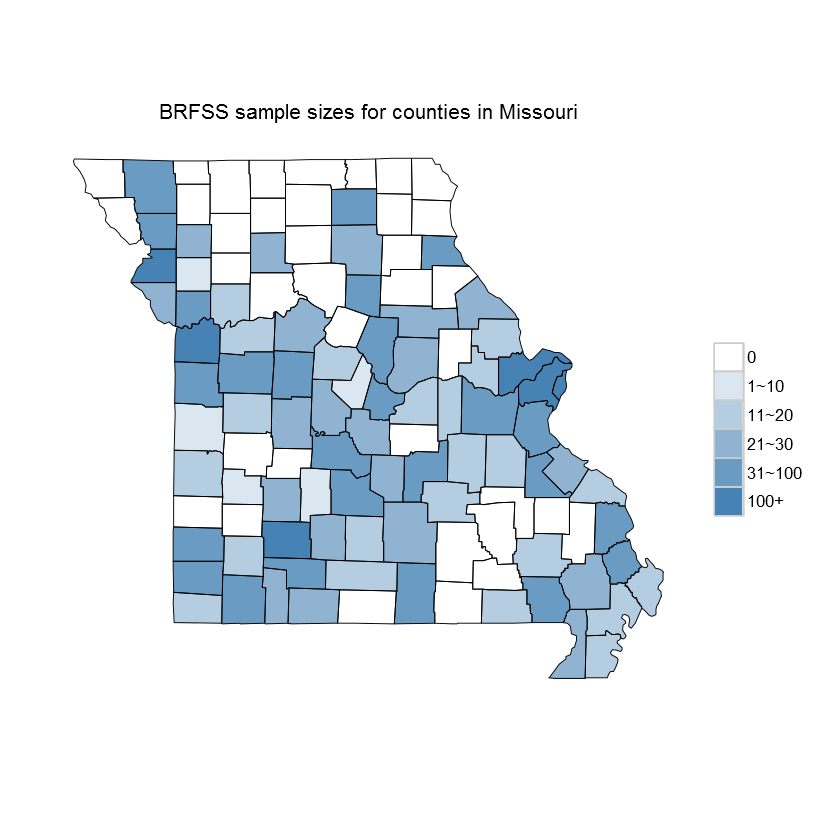

In [3]:
map_mo = map_data('county','missouri')
countyName = read.table('data/countyName.txt',sep=';')
countyName[,1] = as.character(countyName[,1])
get_county_fips = function(x){
  temp = unlist(strsplit(x,'='))
  temp = substr(temp[2], 3, 5)
  return(as.numeric(temp))
}
fips = as.numeric(sapply(countyName[,1],get_county_fips))
names = tolower(countyName[,2])
get_fips_data = function(map_mo,countyName,fips){
  n = length(countyName)
  df = data.frame(orders=1:n,
                  fips = fips,
                  subregion=countyName,
                  label = paste(1:n,countyName,sep='\n '))
  fips_data = merge(map_mo, df, sort = FALSE, by = "subregion")
  fips_data = fips_data[order(fips_data$order),]
  return(fips_data)
}
get_sp_data = function(map_mo,value, names){
  w_df = data.frame(value=value, subregion=names)
  sp_data = merge(map_mo, w_df, sort = FALSE, by = "subregion")
  sp_data = sp_data[order(sp_data$order),]
  return(sp_data)
}
#modify color
get_color = function(c_v){
  return(rgb(c_v[1], c_v[2], c_v[3]))
}
get_color_vector = function(z_min,z_max,z_mean,green_lim=NA){
  nin <- 256
  #nin <- 1000
  nzero <- floor(1 + nin*(z_mean - z_min)/(z_max-z_min))
  maxblue <- .7
  maxred  <- .7
  
  colors <- matrix(NA, nin, 3)
  colors[1:nzero,3] <- 1
  colors[1:nzero,2] <- seq(1 - maxblue, 1, length.out = nzero)
  colors[1:nzero,1] <- colors[1:nzero,2]
  ix <- (nzero+1):nin
  colors[ix, 1] <- 1
  colors[ix, 2] <- seq(1, 1 - maxred, length.out = nin - nzero)
  colors[ix, 3] <- colors[ix, 2]
  if(!is.na(green_lim)){
    colors[,2] <- seq(green_lim[1],green_lim[2], length.out = nin)
  }
  col_vector <- apply(colors, 1, get_color)
  return(col_vector)                 
}
#plot sample size
myPalette <- colorRampPalette(rev(brewer.pal(11, "Spectral")))
sample_county = apply(n_mat, 1, sum)
sample_county_cat = cut(sample_county,breaks=c(-1,0,10,20,30,100,1000),include.lowest = TRUE)
levels(sample_county_cat) = c('0','1~10', '11~20', '21~30', '31~100', '100+')
sample_sp = get_sp_data(map_mo,sample_county_cat, names)

n_level = length(levels(sample_county_cat))
rbPal <- colorRampPalette(c("white","steelblue"))
color_vec = c('grey80', rbPal(n_level)[-1])
sample_plot = ggplot(sample_sp, aes(long, lat)) +
  geom_polygon(data=sample_sp,aes(group=group,fill=value)) +
  scale_fill_manual(values = rbPal(n_level))+
  geom_path(data=sample_sp,aes(group=group), colour = "black", size=0.2) +
  labs(fill='',x="",y="") +
  theme_bw() +
  theme(plot.title = element_text(size=12),
        strip.text.x = element_text(size = 16, colour = "black", angle = 0),
        legend.text = element_text(size=10),
        axis.text=element_blank(),
        panel.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        #strip.background = element_rect(fill="grey90"),
        legend.position = "right",
        strip.background = element_blank(),
        plot.margin = unit(c(0.1,0.1,0.1,0.1), "inch"),
        panel.border=element_blank(), axis.line=element_line(),axis.ticks=element_blank())+
  coord_map()+
  ggtitle('BRFSS sample sizes for counties in Missouri')
print(sample_plot)

In [4]:
sourceCpp('helper.cpp')

In [5]:
I = 115
J = n_class
n_sim = 10000

data_input = data.frame(y=c(y_mat), n=c(n_mat), brfss_region=rep(county2region_df$brfss_region, J),
                        below_high_school = rep(county_attributes$below_high_school, J),
                        below_9th = rep(county_attributes$below_9th, J),
                        above_bach = rep(county_attributes$above_bach, J),
                        median_income =rep( county_attributes$median_income, J),
                        sex = rep(class_dic$sex_vec,each=I),
                        age = rep(class_dic$age_vec,each=I),
                        race = rep(class_dic$race_vec,each=I),
                        class_category = rep(1:12, each=I)
)
brfss_region_factor = factor(data_input$brfss_region)
X_1 =  model.matrix(~brfss_region_factor+
                      factor(data_input$class_category)+
                      data_input$below_high_school + data_input$below_9th + data_input$above_bach+
                      data_input$median_income)
p = ncol(X_1)
mm = diag(I)
X_2 = matrix( rep( t( mm ) , J ) , ncol =  ncol(mm) , byrow = TRUE )
X = cbind(X_1, X_2)

v_post_full = matrix(0, n_sim, I*J)
r_post_full = matrix(0, n_sim, I+p)

v_prev  = rep(1, I*J)
r_prev = c(rep(0,p), rep(1, I))

v_post_full[1,] = v_prev
r_post_full[1,] = r_prev

delta0_post = numeric(n_sim)
eta1_post = numeric(n_sim)
delta1_post = numeric(n_sim)
rho_post = numeric(n_sim)

rho_post[1] = 0.1
delta0_post[1] = 0.2
eta1_post[1] = 1

a0=1
b0=1
delta_beta = 10000

egv = eigen(W)$values
rho_range = sort((1/egv[c(1,length(egv))]))
rho_min = rho_range[1]
rho_max = rho_range[2]

start = Sys.time()
for(i_sim in 2:n_sim){
  v_prev_vec = v_prev
  v_prev_mat = matrix(v_prev_vec, I, J)
  r_prev_vec = r_prev
  z_prev_vec = r_prev_vec[-(1:p)]
  z_prev_mat = matrix(z_prev_vec, I, J)
  delta0_prev = delta0_post[i_sim-1]
  Xr_prev = X%*%r_prev_vec
  Xr_prev_mat = matrix(Xr_prev, I, J)
  
  v_new_mat = sample_v(v_mat=v_prev_mat, y_mat=y_mat, n_mat=n_mat, z_mat=Xr_prev_mat, delta0=delta0_prev, 
                       xl=-6, xr=6, I=I, J=J)
  v_new_vec = c(v_new_mat)
  v_post_full[i_sim,] = v_new_vec
  
  r_new_vec = sample_r_sp(v_vec=v_new_vec, delta0=delta0_prev, rho=rho_post[i_sim-1], C=W, I=I, J=J,
                          p=p, X=X, delta_beta=delta_beta, eta1=eta1_post[i_sim-1])
  r_post_full[i_sim,] = r_new_vec
  z_new_vec = r_new_vec[-(1:p)]
  
  rho_new = sample_rho(xprev=rho_post[i_sim-1], w_vec=z_new_vec, C=W, nu_vec=egv, eta1=eta1_post[i_sim-1],
                       delta0=delta0_prev, K=I, 
                       rho_min=rho_min, rho_max=rho_max)
  rho_post[i_sim] = rho_new
  
  
  a = a0 + I*J/2 + I/2
  v_r = v_new_vec-X%*%r_new_vec
  IrhoC = diag(I) - rho_new*W
  b = b0 + 0.5 *t(v_r)%*%v_r + 0.5 * eta1_post[i_sim-1] * t(z_new_vec)%*%IrhoC%*%z_new_vec
  delta0_new = 1/rgamma(1,a,b)
  delta0_post[i_sim] = delta0_new

  eta1_post[i_sim] = sample_eta1_by_log(xprev=eta1_post[i_sim-1], w_vec=z_new_vec, C=W,
                                        rho=rho_post[i_sim], delta0=delta0_post[i_sim], K=I,xl=-20,xr=20)
  #update prev values
  v_prev = v_new_vec
  r_prev = r_new_vec
}
end = Sys.time()
#difftime(end, start, units='mins')

In [6]:
part = 2001:n_sim
y_in_survey = apply(y_mat, 1, sum, na.rm = TRUE)
Nrest_county = apply(Nrest_mat, 1, sum)
posterior_samples = v_post_full[part,]
proportion_sample = matrix(NA, length(fips), dim(posterior_samples)[1])
for(i in 1:dim(posterior_samples)[1]){
  eta_sample_i = as.numeric(posterior_samples[i,])
  p_sample_i = exp(eta_sample_i)/(1+exp(eta_sample_i))
  p_sample_i_mat = matrix(p_sample_i, length(fips), length(class_names))
  p_county_i = (apply(p_sample_i_mat*Nrest_mat, 1, sum) + y_in_survey)/Nrest_county
  proportion_sample[,i] = p_county_i
}
p_mean_2 = apply(proportion_sample, 1, mean)

In [8]:
cls_data = read.csv('data/Missouri_CLS_modified.csv')
cls_data$Geography = tolower(cls_data$Geography)
#order the counties to have the same layout as we used in our analysis
cls_data[96:115,] = cls_data[c(97:115, 96),]
p_est_cls = 1-(cls_data$Prevalence....)/100

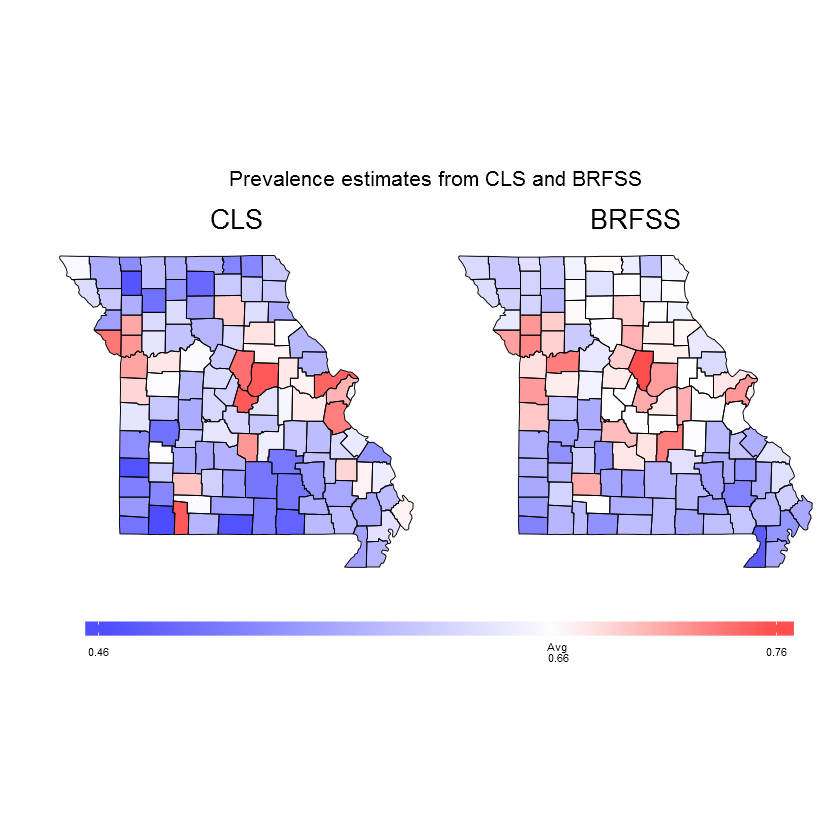

In [9]:
cls_sp = get_sp_data(map_mo,p_est_cls, names)
brfss_sp = get_sp_data(map_mo,p_mean_2, names)
all_p = c(p_est_cls, p_mean_2)
#combine two maps
cls_sp$id = 'CLS'
brfss_sp$id = 'BRFSS'
sp_data = rbind(cls_sp, brfss_sp)
#x_no_NA = p_est_cls#since cls is treated as true value, we use its scale
#statewide average rate based on p_est_cls
stage_avg = sum(N_county*p_est_cls)/sum(N_county)
color_vector = get_color_vector(min(all_p), max(all_p), stage_avg)
sp_data$id_f = factor(sp_data$id, levels = c('CLS', 'BRFSS'))

v_plot = ggplot(sp_data, aes(long, lat)) +
  facet_wrap(~id_f,ncol=2)+
  geom_polygon(data=sp_data,aes(group=group,fill=value)) +
  scale_fill_gradientn("",
                       colours = color_vector,
                       limits = c(min(all_p), max(all_p)),
                       breaks = c(min(all_p), stage_avg,max(all_p)),
                       labels = c(round(min(all_p),2), paste("Avg\n",round(stage_avg,2)), round(max(all_p),2)),
                       na.value = 'grey80')+
  geom_path(data=sp_data,aes(group=group), colour = "black", size=0.2) +
  labs(fill='',x="",y="") +
  theme_bw() +
  theme(plot.title = element_text(size=12),
        strip.text.x = element_text(size = 16, colour = "black", angle = 0),
        legend.text = element_text(size=6),
        axis.text=element_blank(),
        panel.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position = "bottom",
        strip.background = element_blank(),
        panel.border=element_blank(), axis.line=element_line(),axis.ticks=element_blank(),
        legend.key.height = unit(0.3, "cm"),
                                 legend.key.width = unit(3, "cm"),
                                 legend.margin = unit(0, "cm"),
                                 legend.position = "bottom",
                                 legend.text = element_text(size=10))+
  coord_map()+
  ggtitle('Prevalence estimates from CLS and BRFSS')
print(v_plot)

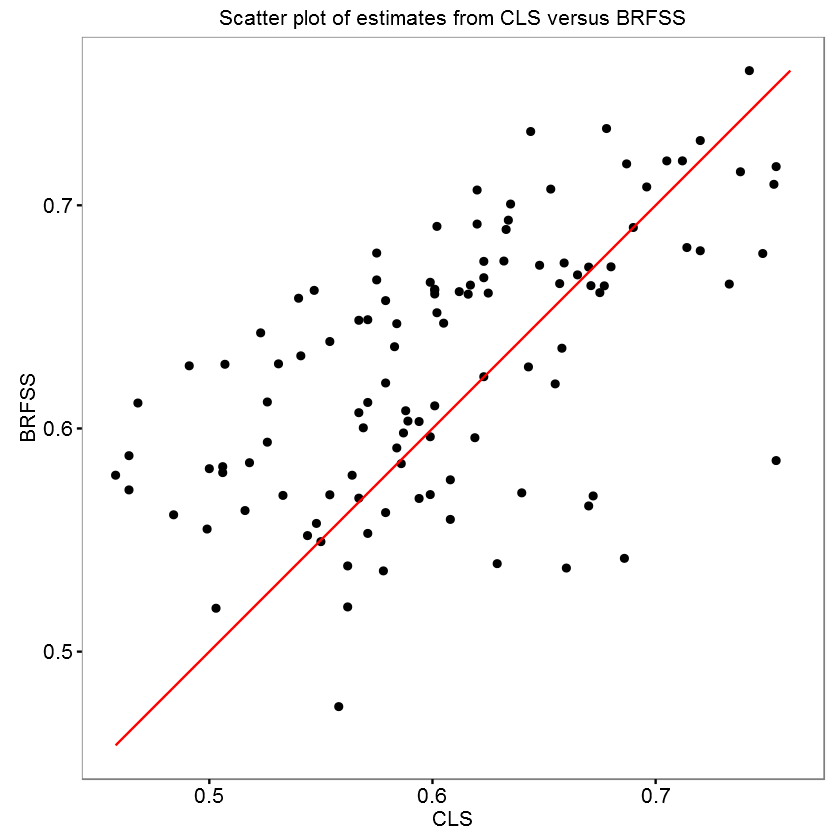

In [10]:
fake_p = seq(min(all_p),max(all_p),length.out = length(p_est_cls))
sample_county = apply(n_mat, 1, sum)
sample_county_cat = cut(sample_county,breaks=c(-1,0,10,20,30,100,1000),include.lowest = TRUE)
levels(sample_county_cat) = c('0','1~10', '11~20', '21~30', '31~100', '100+')
scatter_df = data.frame(cls = p_est_cls, brfss = p_mean_2, sample_size_cat = sample_county_cat, sample_size=sample_county,
                        fake_x = fake_p,fake_y = fake_p)

scatter_plot = ggplot(data=scatter_df, aes(x=p_est_cls, y=brfss))+
  geom_point(colour="black")+
  geom_line(aes(x=fake_x,y=fake_y),colour='red')+
  xlab('CLS')+
  ylab('BRFSS')+
  theme_bw()+
  coord_fixed()+
  theme(plot.title = element_text(size=12),
        strip.text.x = element_text(size = 7, colour = "black", angle = 0),
        legend.text = element_text(size=10),
        axis.text=element_text(size=12),
        panel.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        strip.background = element_rect(fill="grey90"),
        legend.position = "right")+
  ggtitle('Scatter plot of estimates from CLS versus BRFSS')
print(scatter_plot)